# Tutorial for scMusketeers

We will see in this tutorial two use-cases:
- Transfer cell annotation to unlabeled cells
- Transfer cell annotation and reduce batch from a query atlas to a reference atlas 

In [1]:
# Install scMusketeers if needed
#pip install scmusketeers

In [1]:
%%bash
sc-musketeers --help

2024-10-21 14:58:27.614202: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-21 14:58:27.626523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 14:58:27.641625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 14:58:27.646364: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 14:58:27.657521: I tensorflow/core/platform/cpu_feature_guar

/data/analysis/ML_models/conda_env/cb_scmusketeers/bin
tf [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
usage: sc-musketeers [OPTIONS] process atlas_name your_search_folder/

musketeers....

positional arguments:
  process               Type of process to run : Training, Hyperparameter
                        optimization among ['transfer', 'optim']
  ref_path              Path of the referent adata file (example :
                        data/ajrccm.h5ad

options:
  -h, --help            show this help message and exit
  --class_key CLASS_KEY
                        Key of the celltype to classify
  --batch_key BATCH_KEY
                        Key of the batches

Worklow parameters:
  --query_path [QUERY_PATH]
                        Optional query dataset
  --out_dir [OUT_DIR]   The output directory
  --out_name [OUT_NAME]
                        The output naming
  --training_scheme [TRAINING_SCHEME]
  --log_neptune [LOG_NEPTUNE]
  --hparam_path [HPARAM_PATH]
 

## Download Deprez et al. Lung data

Download Deprez et al. Lung cell atlas from Zenodo (https://zenodo.org/records/12581306)

In [1]:
%%bash
cd /data/analysis/data_becavin/scmusketeers/
mkdir data
curl -o data/deprez_lung.h5ad "https://zenodo.org/records/12581306/files/ajrccm_by_batch.h5ad?download=1"

mkdir: impossible de créer le répertoire « data »: Le fichier existe
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2270M  100 2270M    0     0  11.4M      0  0:03:18  0:03:18 --:--:--  101M


In [2]:
import os
import scanpy as sc
working_dir = "/data/analysis/data_becavin/scmusketeers/"
# working_dir = ""
path_h5ad = "data/deprez_lung.h5ad"

In [3]:
adata = sc.read_h5ad(os.path.join(working_dir,path_h5ad))
adata.obs

,donor,manip,method,position,Sex,Age,celltype,phenotype,celltype_phenotype,celltype_position,TRAIN_TEST_split
name,,,,,,,,,,,
D367_Brus_Nas1_CCATGTCTCTAAGCCA-1-27,D367,D367_Brus_Nas1,Brushing,Nasal,male,27,Multiciliated N,CTRL,Multiciliated N_CTRL,Multiciliated N_Nasal,train
D322_Biop_Nas1_CGTCCATCAAATCCGT-1-0,D322,D322_Biop_Nas1,Biopsy,Nasal,female,30,Suprabasal N,CTRL,Suprabasal N_CTRL,Suprabasal N_Nasal,train
D363_Brus_Nas1_GGCAATTTCGATCCCT-1-23,D363,D363_Brus_Nas1,Brushing,Nasal,female,24,Secretory N,CTRL,Secretory N_CTRL,Secretory N_Nasal,train
D353_Brus_Nas1_CCAGCGAGTACACCGC-1-16,D353,D353_Brus_Nas1,Brushing,Nasal,female,30,Multiciliated N,CTRL,Multiciliated N_CTRL,Multiciliated N_Nasal,train
D367_Brus_Nas1_AGGTCCGTCCTGCTTG-1-27,D367,D367_Brus_Nas1,Brushing,Nasal,male,27,Secretory N,CTRL,Secretory N_CTRL,Secretory N_Nasal,train
...,...,...,...,...,...,...,...,...,...,...,...
D367_Biop_Pro1_TCGTAGAGTTTGGGCC-1-28,D367,D367_Biop_Pro1,Biopsy,Proximal,male,27,Basal,CTRL,Basal_CTRL,Basal_Proximal,train
D353_Brus_Nas1_CGGACACTCACCTTAT-1-16,D353,D353_Brus_Nas1,Brushing,Nasal,female,30,Multiciliated N,CTRL,Multiciliated N_CTRL,Multiciliated N_Nasal,train
D367_Biop_Pro1_GTGCATACAGGTCTCG-1-28,D367,D367_Biop_Pro1,Biopsy,Proximal,male,27,Basal,CTRL,Basal_CTRL,Basal_Proximal,train


## Prepare data for the tutorial

In [2]:
import os
import scanpy as sc
working_dir = "/data/analysis/data_becavin/scmusketeers/"
# working_dir = ""
path_h5ad = "data/deprez_lung.h5ad"

2024-11-20 09:28:05.510445: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 09:28:05.522257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-20 09:28:05.535796: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-20 09:28:05.539697: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 09:28:05.550219: I tensorflow/core/platform/cpu_feature_guar

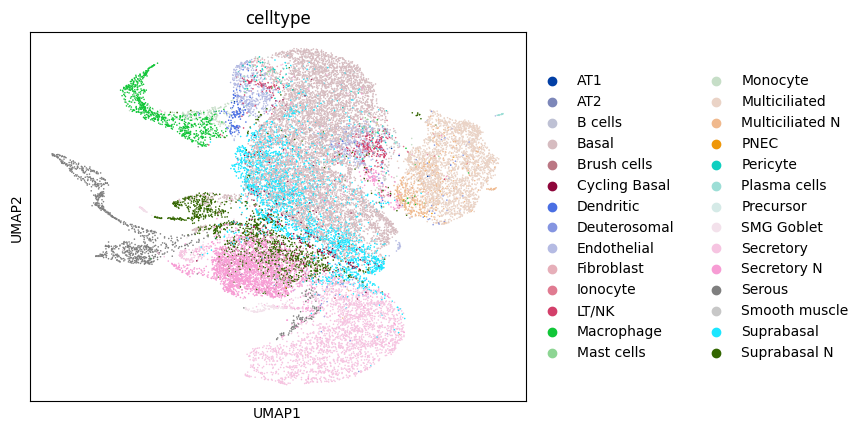

name
D367_Brus_Nas1_AGGTCCGTCCTGCTTG-1-27        Secretory N
D372_Brus_Nas1_GCTTGAAGTTAAGATG-1-31       Suprabasal N
D353_Brus_Dis1_AACTCCCTCTATCGCC-1-19            Unknown
D326_Brus_Dis1_GCGAGAATCTCCAGGG-1-5               Basal
D354_Biop_Pro1_ACGAGGAAGGCCGAAT-1-20            Unknown
                                             ...       
D372_Biop_Pro1_GGAGCAAGTAGTACCT-1-32              Basal
D372_Brus_Nas1_CCCTCCTCAGATGGCA-1-31            Unknown
D353_Biop_Int2_GACTACAGTGTAACGG-1-18            Unknown
D353_Brus_Nas1_CGGACACTCACCTTAT-1-16    Multiciliated N
D339_Biop_Int1_TCGGGACCAAGTTAAG-1-9          Suprabasal
Name: celltype, Length: 23391, dtype: category
Categories (29, object): ['AT1', 'AT2', 'B cells', 'Basal', ..., 'Smooth muscle', 'Suprabasal', 'Suprabasal N', 'Unknown']
10


/data/analysis/ML_models/conda_env/cb_scmusketeers/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/data/analysis/ML_models/conda_env/cb_scmusketeers/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


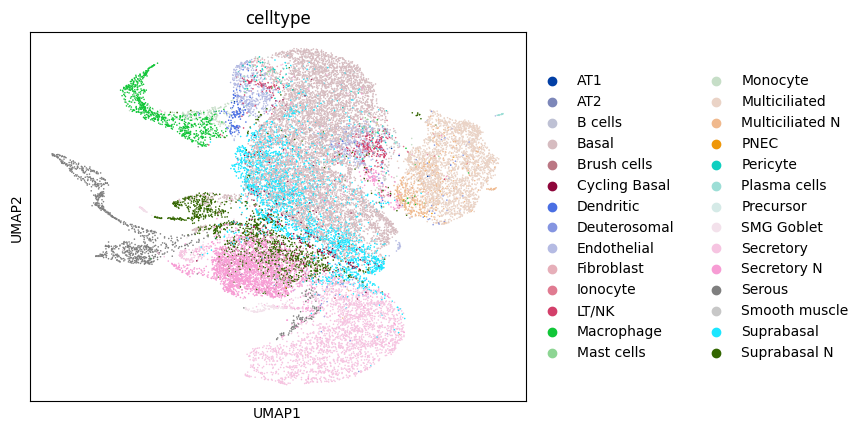

name
D367_Brus_Nas1_AGGTCCGTCCTGCTTG-1-27            Unknown
D372_Brus_Nas1_GCTTGAAGTTAAGATG-1-31       Suprabasal N
D353_Brus_Dis1_AACTCCCTCTATCGCC-1-19            Unknown
D326_Brus_Dis1_GCGAGAATCTCCAGGG-1-5               Basal
D354_Biop_Pro1_ACGAGGAAGGCCGAAT-1-20            Unknown
                                             ...       
D372_Biop_Pro1_GGAGCAAGTAGTACCT-1-32              Basal
D372_Brus_Nas1_CCCTCCTCAGATGGCA-1-31            Unknown
D353_Biop_Int2_GACTACAGTGTAACGG-1-18            Unknown
D353_Brus_Nas1_CGGACACTCACCTTAT-1-16    Multiciliated N
D339_Biop_Int1_TCGGGACCAAGTTAAG-1-9          Suprabasal
Name: celltype, Length: 23391, dtype: category
Categories (29, object): ['AT1', 'AT2', 'B cells', 'Basal', ..., 'Smooth muscle', 'Suprabasal', 'Suprabasal N', 'Unknown']
10


/data/analysis/ML_models/conda_env/cb_scmusketeers/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/data/analysis/ML_models/conda_env/cb_scmusketeers/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


In [6]:
import tutorial
atlas_name = "Deprez-Lung"

class_key = "celltype"
unlabeled_category = "Unknown"
batch_key = "donor"
subsample = 0.3 # keep only this percentage of the atlas 

# Create dataset with 20% unknown cells
sampling_percentage = 0.2
tutorial.create_tuto_data(
    subsample,
    sampling_percentage,
    path_h5ad,
    working_dir,
    atlas_name,
    class_key,
    batch_key,
    unlabeled_category
)

# Create dataset with 40% unknown cells
sampling_percentage = 0.4
tutorial.create_tuto_data(
    subsample,
    sampling_percentage,
    path_h5ad,
    working_dir,
    atlas_name,
    class_key,
    batch_key,
    unlabeled_category
)

## Transfer cell annotation to unlabeled cells (20% unknown)

In [3]:
# read ref adata
atlas_name = "Deprez-Lung"
path_adata=f"data/{atlas_name}-unknown-0.2.h5ad"
adata = sc.read_h5ad(os.path.join(working_dir,path_adata))
print(adata)

AnnData object with n_obs × n_vars = 23391 × 33540
    obs: 'donor', 'manip', 'method', 'position', 'Sex', 'Age', 'celltype', 'phenotype', 'celltype_phenotype', 'celltype_position', 'TRAIN_TEST_split'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'celltype_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'tsne_hg19', 'umap_hg19', 'umap_uncorrected_hg19'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


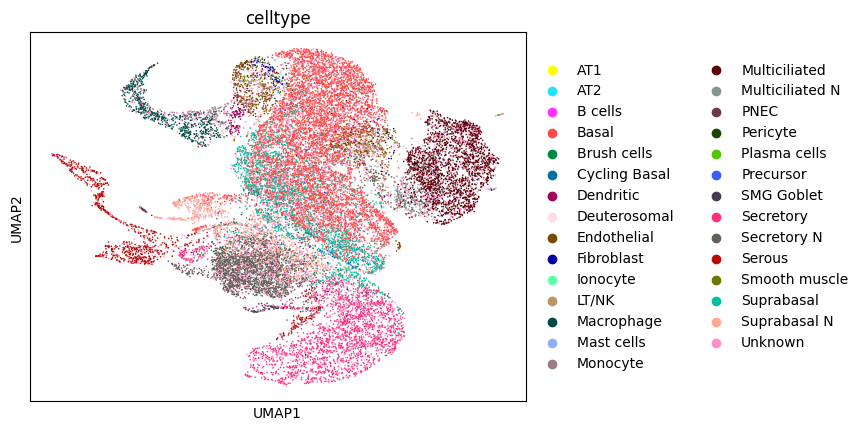

In [4]:
sc.pl.umap(adata, color = "celltype")

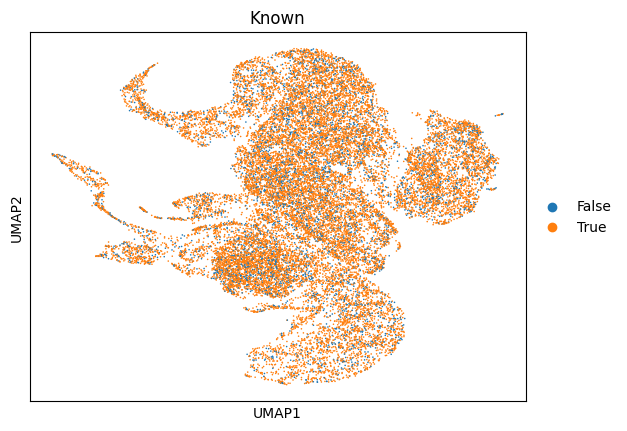

In [5]:
adata.obs["Known"] = adata.obs["celltype"] != "Unknown"
sc.pl.umap(adata, color = "Known")

Run scMusketeers in command line

In [15]:
%%bash
outdir="/data/analysis/data_becavin/scmusketeers"
dataset=${outdir}"/data/Deprez-Lung-unknown-0.2.h5ad"
outname=${outdir}"/data/Deprez-Lung-unknown-0.2-pred"
classkey="celltype"
unlabeled="Unknown"
batchkey="donor"

echo sc-musketeers transfer ${dataset} --class_key=${classkey} --unlabeled_category=${unlabeled} --batch_key=${batchkey} --out_dir=${outdir} --out_name=${outname}

sc-musketeers transfer /data/analysis/data_becavin/scmusketeers/data/Deprez-Lung-unknown-0.2.h5ad --class_key=celltype --unlabeled_category=Unknown --batch_key=donor --out_dir=/data/analysis/data_becavin/scmusketeers --out_name=/data/analysis/data_becavin/scmusketeers/data/Deprez-Lung-unknown-0.2-pred


AnnData object with n_obs × n_vars = 23391 × 26547
    obs: 'donor', 'manip', 'method', 'position', 'Sex', 'Age', 'celltype', 'phenotype', 'celltype_phenotype', 'celltype_position', 'TRAIN_TEST_split', 'true_celltype', 'n_counts', 'size_factors', 'train_split', 'celltype_pred'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'
    uns: 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'celltype_pred_proba', 'tsne_hg19', 'umap_hg19', 'umap_uncorrected_hg19'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


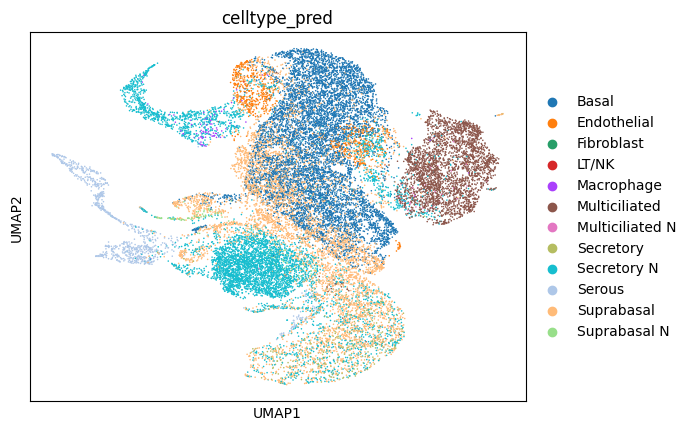

In [12]:
# read predicted adata
atlas_name = "Deprez-Lung"
path_adata=f"data/{atlas_name}-unknown-0.2-pred.h5ad"
adata_pred = sc.read_h5ad(os.path.join(working_dir,path_adata))
print(adata_pred)
sc.pl.umap(adata_pred, color = "celltype_pred")

## Transfer cell annotation and reduce batch from a query atlas to a reference atlas (20% unknown)

In [15]:
# read ref adata
atlas_name = "Deprez-Lung"
path_adata=f"data/{atlas_name}-ref-batch-0.2.h5ad"
ref_adata = sc.read_h5ad(os.path.join(working_dir,path_adata))
print(ref_adata)

AnnData object with n_obs × n_vars = 19055 × 33540
    obs: 'donor', 'manip', 'method', 'position', 'Sex', 'Age', 'celltype', 'phenotype', 'celltype_phenotype', 'celltype_position', 'TRAIN_TEST_split'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'tsne_hg19', 'umap_hg19', 'umap_uncorrected_hg19'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


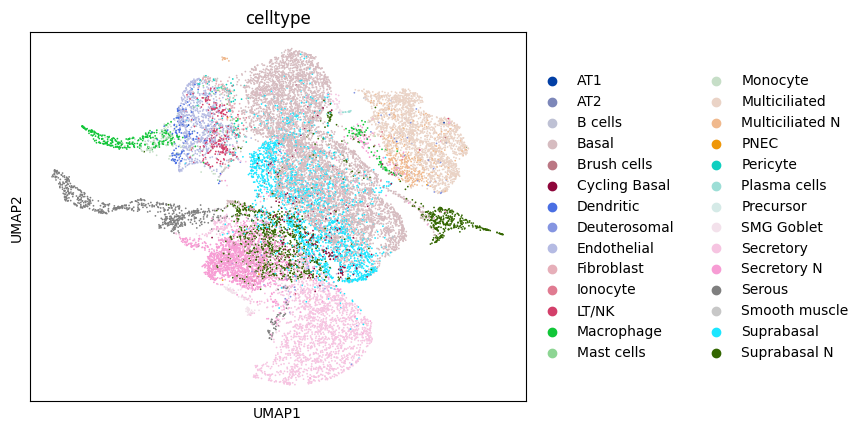

In [16]:
sc.pl.umap(ref_adata, color = "celltype")

In [17]:
# read query adata
path_adata=f"data/{atlas_name}-query-batch-0.2.h5ad"
query_adata = sc.read_h5ad(os.path.join(working_dir,path_adata))
print(query_adata)

AnnData object with n_obs × n_vars = 4336 × 33540
    obs: 'donor', 'manip', 'method', 'position', 'Sex', 'Age', 'celltype', 'phenotype', 'celltype_phenotype', 'celltype_position', 'TRAIN_TEST_split'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'tsne_hg19', 'umap_hg19', 'umap_uncorrected_hg19'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


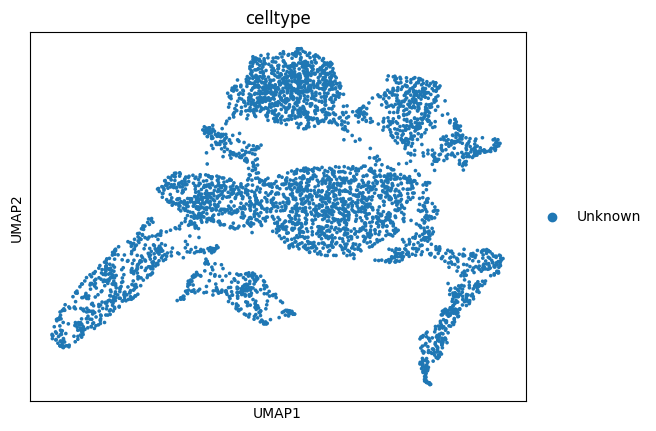

In [18]:
sc.pl.umap(query_adata, color = "celltype")

Run scMusketeers in command line

In [16]:
%%bash
outdir="/data/analysis/data_becavin/scmusketeers"
ref_dataset=${outdir}"/data/Deprez-Lung-ref-batch-0.2.h5ad"
query_dataset=${outdir}"/data/Deprez-Lung-query-batch-0.2.h5ad"

outname=${outdir}"/data/Deprez-Lung-query-batch-0.2-pred"

classkey="celltype"
unlabeled="Unknown"
batchkey="donor"

echo sc-musketeers transfer ${ref_dataset} --query_path ${query_dataset} --class_key=${classkey} --unlabeled_category=${unlabeled} --batch_key=${batchkey} --out_dir=${outdir} --out_name=${outname} 

sc-musketeers transfer /data/analysis/data_becavin/scmusketeers/data/Deprez-Lung-ref-batch-0.2.h5ad --query_path /data/analysis/data_becavin/scmusketeers/data/Deprez-Lung-query-batch-0.2.h5ad --class_key=celltype --unlabeled_category=Unknown --batch_key=donor --out_dir=/data/analysis/data_becavin/scmusketeers --out_name=/data/analysis/data_becavin/scmusketeers/data/Deprez-Lung-query-batch-0.2-pred


AnnData object with n_obs × n_vars = 23391 × 26547
    obs: 'donor', 'manip', 'method', 'position', 'Sex', 'Age', 'celltype', 'phenotype', 'celltype_phenotype', 'celltype_position', 'TRAIN_TEST_split', 'batch', 'true_celltype', 'n_counts', 'size_factors', 'train_split', 'celltype_pred'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'
    uns: 'log1p'
    obsm: 'X_pca', 'X_umap', 'celltype_pred_proba', 'tsne_hg19', 'umap_hg19', 'umap_uncorrected_hg19'


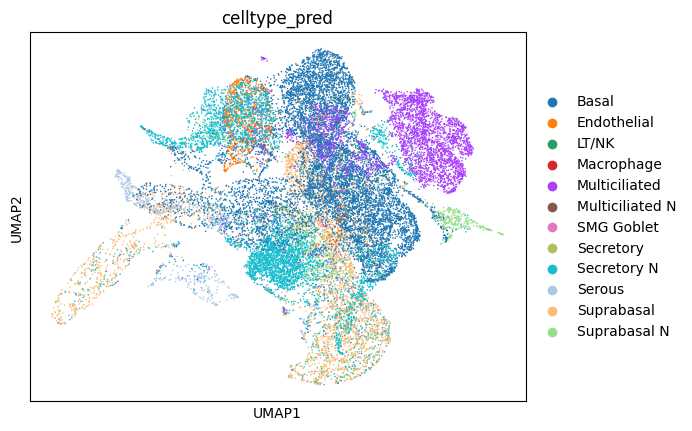

In [23]:
# read predicted adata
path_adata=f"data/{atlas_name}-query-batch-0.2-pred.h5ad"
adata_pred = sc.read_h5ad(os.path.join(working_dir,path_adata))
print(adata_pred)
sc.pl.umap(adata_pred, color = "celltype_pred")

In [24]:
print("ref adata :",ref_adata)
print("query adata :",query_adata)
print("Adata prediction :",adata_pred)


ref adata : AnnData object with n_obs × n_vars = 19055 × 33540
    obs: 'donor', 'manip', 'method', 'position', 'Sex', 'Age', 'celltype', 'phenotype', 'celltype_phenotype', 'celltype_position', 'TRAIN_TEST_split'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'neighbors', 'pca', 'umap', 'celltype_colors'
    obsm: 'X_pca', 'X_umap', 'tsne_hg19', 'umap_hg19', 'umap_uncorrected_hg19'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
query adata : AnnData object with n_obs × n_vars = 4336 × 33540
    obs: 'donor', 'manip', 'method', 'position', 'Sex', 'Age', 'celltype', 'phenotype', 'celltype_phenotype', 'celltype_position', 'TRAIN_TEST_split'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'neighbors', 'pca', 'umap', 'celltype_colors'
    obsm: 'X_pca', 'X_umap', 'tsne_hg19', 'umap_hg19', 'umap_uncorrected_hg19'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
Adata prediction : AnnData object with n_obs × n_vars = 23391 × 26547
    obs: 'donor', 'manip', 'm

## Run scMusketeers in python

In [6]:
import json
from scmusketeers.arguments.runfile import get_runfile, create_argparser
from scmusketeers.arguments.runfile import PROCESS_TYPE
from scmusketeers.transfer.optimize_model import Workflow
from scmusketeers.transfer.experiment import MakeExperiment
import pickle

/data/analysis/ML_models/conda_env/cb_scmusketeers/lib/python312.zip


2024-11-20 11:38:44.496486: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 11:38:44.508942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-20 11:38:44.523742: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-20 11:38:44.528416: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 11:38:44.540804: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
# Prepare scMusketeers
import os
print(os.getcwd())
with open('runfile_tuto_2.pkl', 'rb') as inp:
    run_file = pickle.load(inp)
run_file.train_scheme = "training_scheme_13"
working_dir = "/data/analysis/data_becavin/scmusketeers/"
atlas_name="Deprez-Lung"
path_ref_adata=os.path.join(working_dir,f"data/{atlas_name}-ref-batch-0.2.h5ad")
run_file.ref_path = path_ref_adata
path_query_adata=os.path.join(working_dir,f"data/{atlas_name}-query-batch-0.2.h5ad")
run_file.query_path = path_query_adata

print(run_file.ref_path, run_file.class_key, run_file.batch_key)
workflow = Workflow(run_file=run_file)
workflow.process_dataset()
workflow.train_val_split()
adata_pred, model, history, X_scMUS, query_pred  = workflow.make_experiment()        

/home/becavin/scMusketeers/tutorial
/data/analysis/data_becavin/scmusketeers/data/Deprez-Lung-ref-batch-0.2.h5ad celltype donor


/home/becavin/scMusketeers/scmusketeers/transfer/dataset_tf.py:98: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = ref.concatenate(query, join="inner")
/home/becavin/scMusketeers/scmusketeers/transfer/dataset_tf.py:238: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.adata_train_extended.obs["train_split"] = spl.values


Unknown
['Secretory N' 'Suprabasal N' 'Secretory' 'Basal' 'Multiciliated' 'Serous'
 'Endothelial' 'Multiciliated N' 'Suprabasal' 'Macrophage' 'Monocyte'
 'Fibroblast' 'SMG Goblet' 'Cycling Basal' 'LT/NK' 'Pericyte' 'B cells'
 'Mast cells' 'Deuterosomal' 'Dendritic' 'Smooth muscle' 'Plasma cells'
 'PNEC' 'Ionocyte' 'Precursor' 'Brush cells' 'AT1' 'AT2' 'Unknown']
4336
adam
Training scheme : training_scheme_13, warmup 2
adam
Epoch 1/2, Current strat Epoch 1/1
use_perm = True
switching perm
0/3811 - total loss: 0.5337 - classification loss: 1.4883 - dann loss: 3.3436 - reconstruction loss: 0.063229adam
Epoch 2/2, Current strat Epoch 1/1
use_perm = False
switching perm
0/3811 - total loss: 0.0985 - classification loss: 0.9847 - dann loss: 2.9253 - reconstruction loss: 0.049001AnnData object with n_obs × n_vars = 23391 × 26547
    obs: 'donor', 'manip', 'method', 'position', 'Sex', 'Age', 'celltype', 'phenotype', 'celltype_phenotype', 'celltype_position', 'TRAIN_TEST_split', 'batch', 'true_

In [13]:
print(adata_pred)
print(query_pred)

AnnData object with n_obs × n_vars = 23391 × 26547
    obs: 'donor', 'manip', 'method', 'position', 'Sex', 'Age', 'celltype', 'phenotype', 'celltype_phenotype', 'celltype_position', 'TRAIN_TEST_split', 'batch', 'true_celltype', 'n_counts', 'size_factors', 'train_split', 'celltype_pred'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'
    uns: 'log1p'
    obsm: 'X_pca', 'X_umap', 'tsne_hg19', 'umap_hg19', 'umap_uncorrected_hg19', 'celltype_pred_proba'
['Suprabasal' 'Suprabasal' 'Suprabasal' ... 'Suprabasal' 'Suprabasal'
 'Basal']
